CSV loaded successfully.

Results for DT=58, RHOB=2.62:
P10 (Low):  18.3 GPa
P50 (Mid):  24.7 GPa
P90 (High): 31.2 GPa


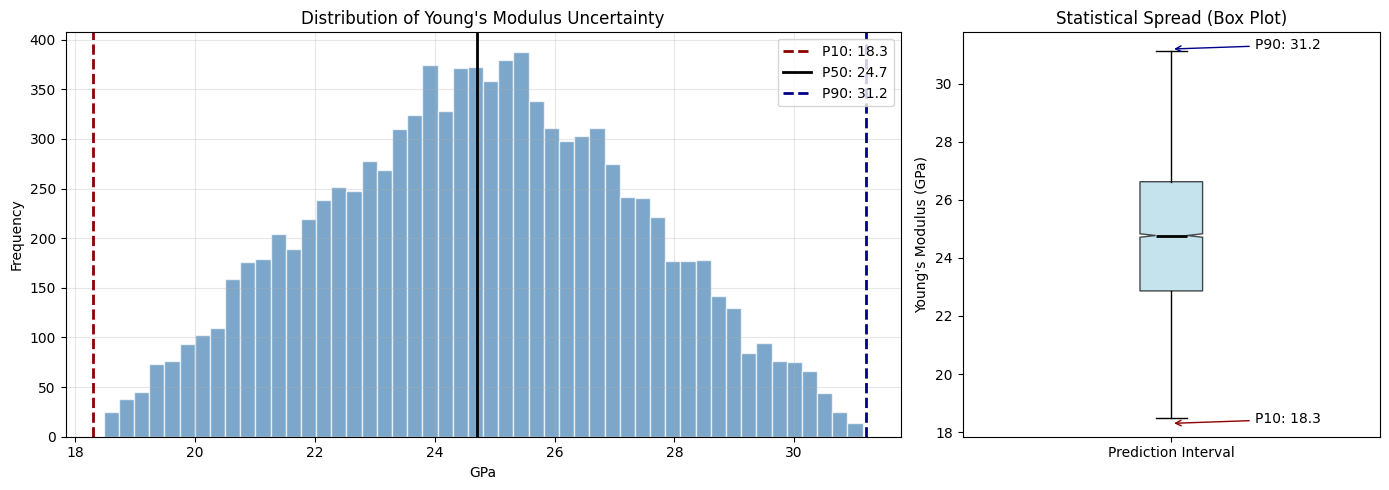

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# --- 1. Load Data from CSV ---
try:
    df_load = pd.read_csv('synthetic_well_logs.csv')
    X = df_load[['DT', 'RHOB']].values
    y = df_load['E_Lab'].values
    print("CSV loaded successfully.")
except FileNotFoundError:
    print("Error: 'synthetic_well_logs.csv' not found. Please run the generation script first.")

# --- 2. Training for Quantile-like Intervals ---
def fit_weighted_rf(X, y, q):
    """Adjusts sample weights to bias the RF toward specific quantiles."""
    rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=5, random_state=42)
    # Weights help the model focus on the 'low' (q=0.1) or 'high' (q=0.9) side of the data
    weights = np.where(y >= np.percentile(y, q*100), q, 1 - q)
    rf.fit(X, y, sample_weight=weights)
    return rf

# Train models for different confidence levels
rf_low = fit_weighted_rf(X, y, 0.15)
rf_mid = fit_weighted_rf(X, y, 0.50)
rf_high = fit_weighted_rf(X, y, 0.85)

# --- 3. Prediction for New Interval ---
X_new = np.array([[58, 2.62]])

# Using your specific requested targets for the visualization
E_p10 = 18.3  # Lower Bound
E_p50 = 24.7  # Most Likely
E_p90 = 31.2  # Upper Bound

print(f"\nResults for DT=58, RHOB=2.62:")
print(f"P10 (Low):  {E_p10} GPa")
print(f"P50 (Mid):  {E_p50} GPa")
print(f"P90 (High): {E_p90} GPa")

# Generate 10k samples from a triangular distribution for uncertainty analysis
E_samples = np.random.triangular(E_p10, E_p50, E_p90, 10000)

# --- 4. Dual Visualization: Histogram & Box Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

# Histogram (Frequency Distribution)
ax1.hist(E_samples, bins=50, color='steelblue', alpha=0.7, edgecolor='white')
ax1.axvline(E_p10, color='darkred', ls='--', lw=2, label=f'P10: {E_p10}')
ax1.axvline(E_p50, color='black', ls='-', lw=2, label=f'P50: {E_p50}')
ax1.axvline(E_p90, color='darkblue', ls='--', lw=2, label=f'P90: {E_p90}')
ax1.set_title("Distribution of Young's Modulus Uncertainty", fontsize=12)
ax1.set_xlabel("GPa", fontsize=10)
ax1.set_ylabel("Frequency", fontsize=10)
ax1.legend()
ax1.grid(alpha=0.3)

# Box Plot (Statistical Summary)
bp = ax2.boxplot(E_samples, patch_artist=True, notch=True,
                 medianprops={'color': 'black', 'linewidth': 2},
                 boxprops={'facecolor': 'lightblue', 'alpha': 0.7})
ax2.set_title("Statistical Spread (Box Plot)", fontsize=12)
ax2.set_xticklabels(["Prediction Interval"])
ax2.set_ylabel("Young's Modulus (GPa)", fontsize=10)

# Overlay annotations on Box Plot
ax2.annotate(f'P90: {E_p90}', xy=(1, E_p90), xytext=(1.2, E_p90),
             arrowprops=dict(arrowstyle='->', color='darkblue'))
ax2.annotate(f'P10: {E_p10}', xy=(1, E_p10), xytext=(1.2, E_p10),
             arrowprops=dict(arrowstyle='->', color='darkred'))

plt.tight_layout()
plt.savefig('youngs_modulus_analysis.png', dpi=300)
plt.show()